# Events Table Stratified

__Description__: 
A stratified sampling of runoff events is performed on a runoff distribution derived from 
- Rainfall distribution based on the NOAA Atlas 14 (or mean precipitation curve) data (area averaged) and
- Max. potential retention distribution based on a beta distribution.

The rainfall distribution is assumed to be represented by a generalized extreme value distribution (GEV). This GEV distribution is fitted to the data (NOAA Atlas 14 data or corresponding values for the mean precipitation curve). The maximum potential distribution variabilitity corresponds to the curve number (CN) dispersion documented by the NRCS. For the rainfall distribution and runoff distribution, this notebook sequentially calculates 
- GEV distribution parameters for the NOAA or mean precipitation curve data
- Rainfall values and probability weights for different return period events
- Max potential retention variability and distribution parameters
- Partition for the max potential distribution for calculating the runoff distribution
- Runoff as a function of the return interval (i.e., return period)
- Runoff event probability weights
- A stratified sampling of runoff, where for each return interval the sampling includes
    - Event weight
    - Runoff value
    - Max. potential retention value
    - Rainfall value
    

__Input__: 
- Parameters: curve number and initial abstraction ratio; the probable maximum precipitation; return intervals for stratified sampling; maximum return interval limit for the stratified sampling bins;  the volume, region, and duration ([See map for volume and region](https://hdsc.nws.noaa.gov/hdsc/pfds/pfds_temporal.html)).
        
- The area averaged precipitation frequency data for the specified duration.

- `DataRepository` folder which contains the following:
    - The *NEH630_Table_10_1.json* which contains information about the spread of possible values around the provided (expected) curve number. [Source](https://www.wcc.nrcs.usda.gov/ftpref/wntsc/H&H/NEHhydrology/ch10.pdf).


__Output__: TBD


---
## Load Libraries, Parameters, and Data:
### Libraries:

In [1]:
import sys
sys.path.append('../../core')
from hydromet import*
from hydromet_stratified import*
import hydromet_JSON_to_DSS_v2
import mean_frequency_curve
%matplotlib inline

### Parameters: 
#### Local (site specific):

In [2]:
## Excess rainfall parameters:
CN  = 66  # Curve number, must be an integer
mu  = 0.2  # Intial abstraction ratio parameter
PMP = 21.92  # [inches]; Probable maximum precipitation for the selected duration 
Return_Intervals = np.array([2, 5, 10, 25, 50, 100, 200, 500, 1000, 2000, 3000])  # Return intervals for calculating runoff values.
RI_upper_bound = 3700  # Upper Limit of recurrence interval evaluation, suggest not changing this value
lower_limit = 1 # Lower limit of NOAA Atlas 14 precipitation values
Aerial_Reduction = 0.9216  # Aerial reduction factor
duration = 24  # [hours]; Event duration;  must be a duration in the input Precip_Table file
Time_Extend = 12.0; # Model run time extension beyond the hyetograph (24-hour) period.

## Mean curve parameters:
return_intervals_mc = np.array([1.01, 1.05, 1.11, 1.25, 20, 2000, 5000, 10000, 20000, 50000, 100000, 200000, 1/2E-06, 1/1E-06, 1/5E-07, 1/2E-07, 1/1E-07]) # Additional return intervals for the mean curve inputs
CL = np.array([0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99, 0.995, 0.999]) # Confidence limits

## Integration parameter:
n_partition = 30  # Define number of partitions of max potential retention distribution; this controls the resolution of the integration of int p(Q|S)p(S) dS

## Filenames and paths:
Project_Area = 'Concord'  # Project area name
Pluvial_Model = 'P01'  # Pluvial model name
BCN = '01070005'  # Domain/boundary condition name
precip_table = '{0}_{1}_{2}_PrecipTable.xlsx'.format(Project_Area, Pluvial_Model, BCN)  # NOAA Data
precip_mean_curve_input_table = f'Mean_Curve_Input_{Project_Area}.csv'
precip_mean_curve_table = f'MeanCurve_{Project_Area}.csv'
CN_Distribution = 'NEH630_Table_10_1.json'
nrcs_precip_table = '{0}_{1}_{2}__nrcs_PrecipTable.xlsx'.format(Project_Area, Pluvial_Model, BCN)  # NRCS Data
atlas14_precip_table = '{0}_{1}_{2}_atlas_temporal_PrecipTable.xlsx'.format(Project_Area, Pluvial_Model, BCN)  # Atlas 14 Temporal Data


root_dir = pl.Path(os.getcwd())
outputs_dir = root_dir/'Outputs'
precip_table_dir = outputs_dir/precip_table
nrcs_precip_table_dir = outputs_dir/nrcs_precip_table
atlas14_precip_table_dir = outputs_dir/atlas14_precip_table
precip_mean_curve_input_table_dir = outputs_dir/precip_mean_curve_input_table
precip_mean_curve_table_dir = outputs_dir/precip_mean_curve_table
datarepository_dir = root_dir.parent.parent/'DataRepository'
bin_dir = root_dir.parent.parent/'bin'

## Options:
display_print = False
np.set_printoptions(suppress=True)

##### Convert all paths to objects:

In [3]:
outputs_dir = pl.Path(outputs_dir)
precip_table_dir = pl.Path(precip_table_dir)
precip_mean_curve_input_table_dir = pl.Path(precip_mean_curve_input_table_dir)
precip_mean_curve_table_dir = pl.Path(precip_mean_curve_table_dir)
datarepository_dir = pl.Path(datarepository_dir)

### Data:
#### NOAA Atlas 14 precipitation values:

,Median,Lower (90%),Upper (90%)
Tr,,,
1,2.669244,2.140739,3.279545
2,3.269051,2.618799,4.020598


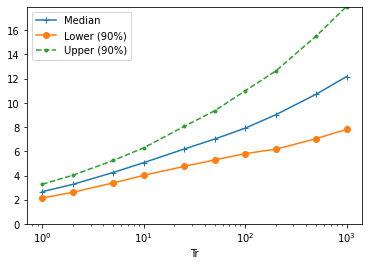

In [4]:
raw_precip = get_input_data(precip_table_dir, duration, lower_limit, display_print)
raw_precip.rename(columns = {'Expected Value': 'Median'}, inplace = True)
raw_precip.plot(style=['+-','o-','.--'], logx=True, ylim=(0, raw_precip['Upper (90%)'].max()))
raw_precip.head(2)

#### Fit GEV to rainfall data (find GEV parameters):

In [5]:
## Reduce precipitation by aerial reduction factor:
raw_precip_reduced = raw_precip[raw_precip.select_dtypes(include=['number']).columns]*Aerial_Reduction

## Find GEV parameter values:
df_GEV_parameters_M = GEV_parameters_Fit(raw_precip_reduced, 'Median', PMP)
df_GEV_parameters_U = GEV_parameters_Fit(raw_precip_reduced, 'Upper (90%)', PMP)
df_GEV_parameters_L = GEV_parameters_Fit(raw_precip_reduced, 'Lower (90%)', PMP)
df_GEV_parameters = pd.concat([df_GEV_parameters_M, df_GEV_parameters_L, df_GEV_parameters_U], axis=1)
df_GEV_parameters

../../core\hydromet_stratified.py:60: RuntimeWarning:

divide by zero encountered in double_scalars



,GEV Median,GEV Lower (90%),GEV Upper (90%)
mu,2.890760,2.326520,3.536559
sigma,0.642937,0.568239,0.742524
xi,-0.167038,-0.057431,-0.264276


#### Plot fitted GEV distribution and NOAA data:

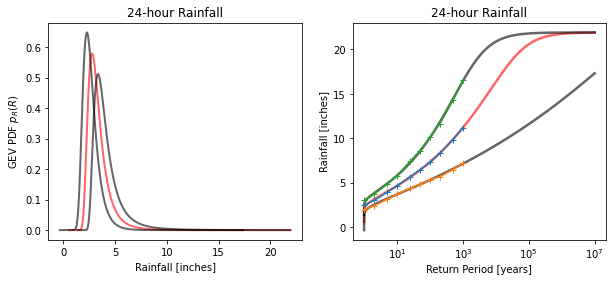

In [6]:
plot_GEV_precip_curves(raw_precip_reduced, df_GEV_parameters, PMP, 'Rainfall')

---
## Hydrology 1

In [156]:
Return_Intervals_Hydro1 = np.array([10, 25, 50, 100, 500])  # Hydrology 1 Return intervals for calculating runoff values.
GEV_parameters_M = df_GEV_parameters_M.values.transpose()[0]
df_weights_rainfall = weights_Rainfall(Return_Intervals_Hydro1, GEV_parameters_M, PMP, RI_upper_bound, raw_precip_reduced, 'Median', CN, mu)
#Add last event weight to the last event listed in the return intervals array
df_weights_rainfall['Event Weight'].iloc[-2]=df_weights_rainfall['Event Weight'].iloc[-2]+df_weights_rainfall['Event Weight'].iloc[-1]
#drop the last event containing the rainfall amount of to the PMP
df_weights_rainfall = df_weights_rainfall[:-1] #.head(2)
df_weights_rainfall

,Bin Floor,Bin Ceiling,Event Weight,Median,Runoff
10,6.762891,16.793707,0.088320,4.666400,1.504527
25,16.793707,42.399259,0.035961,5.698482,2.219203
50,42.399259,60.067119,0.006937,6.460388,2.786519
100,60.067119,210.880613,0.011906,7.289628,3.433503
500,210.880613,3700.000000,0.004742,9.869161,5.584226


In [157]:
##hydro1 events
hydro1_evnts = [10, 25, 50, 100, 500] #Uses median rainfall values for 5 events (10, 25, 50, 100, 500 yr events)

precip_distros1 = {}
runoff_distros1 = {}
final_c_input = {}
prep_curves = pd.DataFrame(columns = hydro1_evnts)

for evnt in hydro1_evnts:
    dist_df = get_hyeto_input_data(nrcs_precip_table_dir,evnt,display_print)
    dist_df['precip'] = dist_df['ratio']*raw_precip_reduced['Median'].loc[evnt]
    s = S_24hr(CN)
    ia = IA_24hr(s)
    dist_df['excess_precip'] = np.where(dist_df['precip']<= ia ,0,(np.square(dist_df['precip']-ia))/(dist_df['precip']-ia+s))
    dist_df['hyeto_input'] = dist_df['excess_precip'].diff()
    dist_df['hyeto_input'] = dist_df['hyeto_input'].fillna(0.0)
    dist_df['sim_time'] = (dist_df['t_step'].astype(int)).astype(str)+':'+ ((round((dist_df['t_step'] - dist_df['t_step'].astype(int))*60)).astype(int)).astype(str)
    runoff_distros1[evnt] = dist_df
    prep_curves[evnt] = dist_df['hyeto_input']

In [141]:
#hyetographs in pandas dataframe
prep_curves.rename_axis('hours')
prep_curves.index = prep_curves.index.astype(float)
extend_curves = prep_curves.loc[0.0:Time_Extend]*0
extend_curves.index = extend_curves.index+24.1
extend_curves.rename_axis('hours')
final_curves = prep_curves.append(extend_curves).rename_axis('hours')

[]

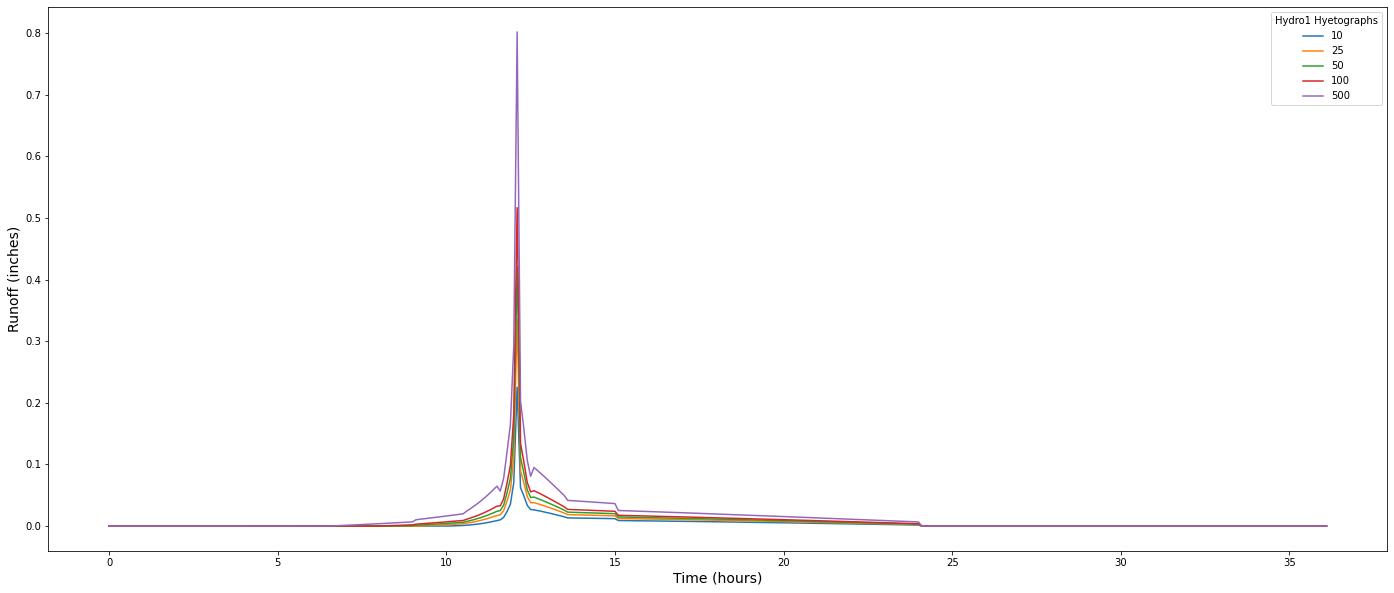

In [142]:
#test
t_p = final_curves.plot(figsize=(24,10))
t_p.legend(title='Hydro1 Hyetographs')
t_p.set_xlabel('Time (hours)', fontsize=14)
t_p.set_ylabel('Runoff (inches)',fontsize=14)
t_p.plot()

In [14]:
Event_Weights_Hydro = df_weights_rainfall['Event Weight'].to_dict()

rename_map = Rename_Final_Groups_Precip_Stratified(Event_Weights_Hydro,24) #set naming convention
renamed_groups = {}
renamed_tests = {}
renamed_weights = {}

for k, v in rename_map.items():
    renamed_groups[v] = final_curves[k]
    renamed_weights[v] = Event_Weights_Hydro [k]

renamed_weights

{'E2001': 0.08831964142611004,
 'E2002': 0.035960797729311454,
 'E2003': 0.006937274628524576,
 'E2004': 0.011906023764036926,
 'E2005': 0.004742019608707512}

In [15]:
renamed_curves = final_curves.rename(index=float, columns=rename_map).copy()
renamed_curves = renamed_curves.reindex(sorted(renamed_curves.columns), axis=1)
renamed_curves.head(100)

,E2001,E2002,E2003,E2004,E2005
hours,,,,,
0.0,0.0,0.000000,0.000000,0.000000,0.000000
0.1,0.0,0.000000,0.000000,0.000000,0.000000
0.2,0.0,0.000000,0.000000,0.000000,0.000000
0.3,0.0,0.000000,0.000000,0.000000,0.000000
0.4,0.0,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...
9.5,0.0,0.000836,0.002566,0.004717,0.012929
9.6,0.0,0.001110,0.002907,0.005134,0.013602
9.7,0.0,0.001388,0.003253,0.005557,0.014282


In [16]:
#convert weighting table to pandas dataframe
df_renamed_weights = pd.DataFrame(data = {'Weight':list(renamed_weights.values())}, index = list(renamed_weights.keys())) 
df_renamed_weights 

,Weight
E2001,0.088320
E2002,0.035961
E2003,0.006937
E2004,0.011906
E2005,0.004742


### Save Data

In [17]:
#write excess rainfall events to json
excess_dic = hydro_out_to_dic(renamed_curves,BCN)

with open(outputs_dir/'{0}_{1}_{2}_{3}.json'.format(Project_Area, Pluvial_Model, BCN,'Hydro1'), 'w') as f:
    json.dump(excess_dic, f)

In [18]:
#write excess rainfall events to dss
forcing = '{0}_{1}_{2}_{3}_Forcing'.format(Project_Area, Pluvial_Model, BCN,'Hydro1')

hydromet_JSON_to_DSS_v2.main(outputs_dir, outputs_dir, bin_dir, forcing, remove_temp_files = True, display_print = True)

Converting Concord_P01_01070005_Hydro1.json to DSS...
Dss File written to C:\Users\mbartlettjr\Documents\GitHub\pfra-hydromet\Notebooks\pluvial\Outputs\Concord_P01_01070005_Hydro1_Forcing.dss


In [19]:
#write event weights to json
with open(outputs_dir/'weights'/'{0}_{1}_{2}_{3}_Weights.json'.format(Project_Area, Pluvial_Model, BCN,"Hydro1"), 'w') as f:
    json.dump(renamed_weights, f)
    
#write recurrence interval to json
with open(outputs_dir/'weights'/'{0}_{1}_{2}_{3}_Recurrence.json'.format(Project_Area, Pluvial_Model, BCN,"Hydro1"), 'w') as f:
    json.dump(rename_map, f)

In [20]:
#write events to excel for reference only
writer = pd.ExcelWriter(outputs_dir/'{0}_{1}_{2}_hyeto_input_Table.xlsx'.format(Project_Area, Pluvial_Model, BCN))

for i, d in enumerate(hydro1_evnts):
    table = runoff_distros1[d][['sim_time','hyeto_input']]
    table.to_excel(writer, sheet_name = 'ras_input_{}'.format(hydro1_evnts[i]))
 
writer.save()

## Mean Curve Calculation
#### Data for calculating the mean curve:

In [21]:
return_interval_data = return_interval_data(raw_precip_reduced, return_intervals_mc, df_GEV_parameters, PMP)
return_interval_data.head(2)

,Median,Lower (90%),Upper (90%),Log SD (Lower),Log SD (Upper),Max Log SD,mu LN
1.00,2.459975,1.972905,3.022428,0.134130,0.125173,0.134130,0.900151
1.01,2.023037,1.494561,2.602389,0.184053,0.153088,0.184053,0.704600


#### Input for calculating the mean curve:

In [22]:
mean_curve_data = mean_curve_input_table(CL, return_interval_data, PMP, precip_mean_curve_input_table_dir)
mean_curve_data.head(2)

,0.001,0.005,0.010,0.050,0.100,0.200,0.300,0.400,0.500,0.600,0.700,0.800,0.900,0.950,0.990,0.995,0.999
AEP,,,,,,,,,,,,,,,,,
1.000000e-07,20.953807,21.173817,21.269509,21.493911,21.591519,21.689713,21.747426,21.788498,21.820426,21.846560,21.868687,21.887879,21.904826,21.912611,21.918552,21.919278,21.919856
2.000000e-07,20.473255,20.798815,20.941126,21.276545,21.423186,21.571163,21.658350,21.720493,21.768857,21.808479,21.842053,21.871192,21.896937,21.908768,21.917799,21.918902,21.919781


##### Calculate the mean precipitation curve:

Specified inputs_path is to a csv, loaded table.

Values increase with decreasing annual exceedance probability for all confidence limits as expected



,P_Mean_in,P_Median_in
AEP,,
0.9,2.257539,2.390323
0.5,3.108133,3.012757


C:\Users\mbartlettjr\Documents\GitHub\pfra-hydromet\Notebooks\pluvial\Outputs - already exists



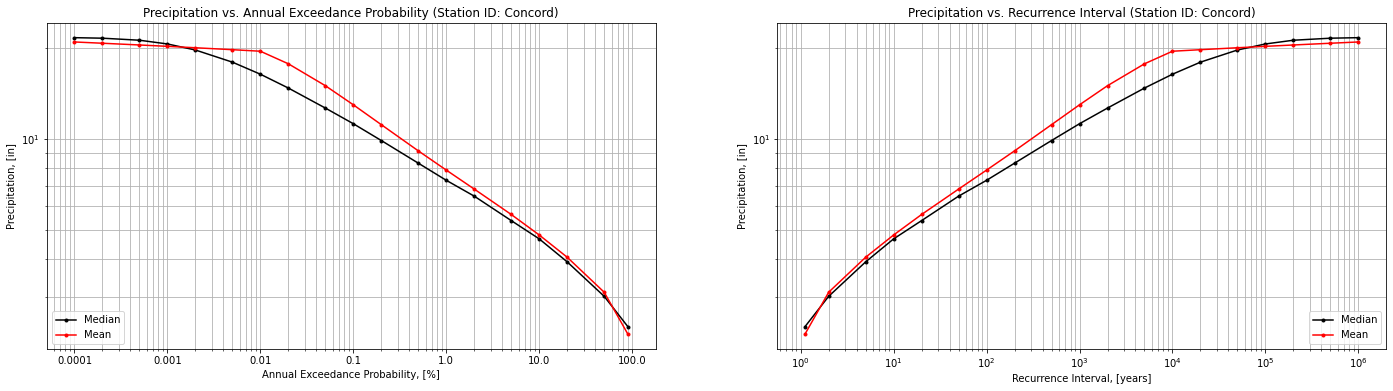

In [23]:
df = mean_frequency_curve.main(Project_Area, precip_mean_curve_input_table_dir, outputs_dir, data_type = 'P', round_decimals = 6)

---
## Hydrology 2
### Load Mean Curve:

,P_Mean_in,P_Median_in
Tr,,
1.111111,2.257539,2.390323
2.000000,3.108133,3.012757


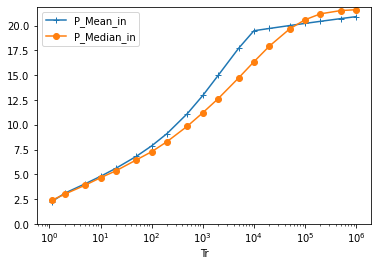

In [24]:
mean_curve_precip = pd.read_csv(precip_mean_curve_table_dir, index_col=0)
mean_curve_precip['Tr'] = 1.0/mean_curve_precip.index.values
mean_curve_precip.set_index('Tr', inplace = True)
mean_curve_precip.plot(style=['+-', 'o-'], logx=True, ylim=(0, PMP))
mean_curve_precip.head(2)

### Fit GEV to Mean Precipication Curve (Find GEV Parameters):

In [25]:
fit_values_mean_curve_precip = mean_curve_precip[1:20000] # Only fit the value up to about the 20,000 year event
df_GEV_parameters_E = GEV_parameters_Fit(fit_values_mean_curve_precip, 'P_Mean_in', PMP)
GEV_parameters_E = df_GEV_parameters_E.values.transpose()[0]
df_GEV_parameters = pd.concat([df_GEV_parameters, df_GEV_parameters_E], axis=1)
df_GEV_parameters 

,GEV Median,GEV Lower (90%),GEV Upper (90%),GEV P_Mean_in
mu,2.890760,2.326520,3.536559,2.810839
sigma,0.642937,0.568239,0.742524,0.648021
xi,-0.167038,-0.057431,-0.264276,-0.223991


#### Plot fitted GEV distribution and mean precipitation curve:

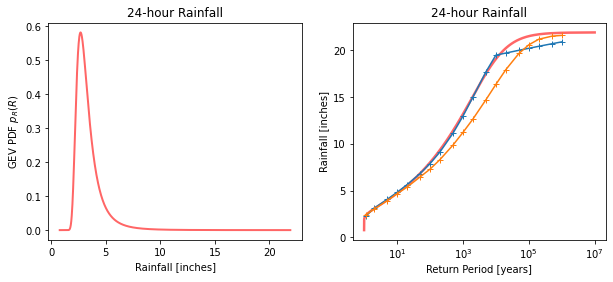

In [26]:
plot_GEV_precip_curves(mean_curve_precip, df_GEV_parameters_E, PMP, 'Rainfall')

### Hydrology 2 Events:

In [119]:
df_weights_rainfall = weights_Rainfall(Return_Intervals, GEV_parameters_E, PMP, RI_upper_bound, mean_curve_precip, 'P_Mean_in', CN, mu)
df_weights_rainfall #.head(2)

,Bin Floor,Bin Ceiling,Event Weight,P_Mean_in,Runoff
2.0,1.258017,4.098856,0.550932,3.108133,0.597202
5.0,4.098856,6.272738,0.084551,4.056980,1.120147
10.0,6.272738,19.217669,0.107385,4.806680,1.597356
25.0,19.217669,34.140017,0.022744,5.836497,2.319761
50.0,34.140017,81.936516,0.017087,6.818200,3.062299
100.0,81.936516,125.369416,0.004228,7.879282,3.908882
200.0,125.369416,384.137268,0.005373,9.122543,4.944545
500.0,384.137268,684.985170,0.001143,11.136707,6.694189
1000.0,684.985170,1647.695069,0.000853,12.955218,8.327478
2000.0,1647.695069,2498.790989,0.000207,14.984984,10.192145


In [120]:
hyeto_graphs = np.where(df_weights_rainfall.index.to_numpy().astype(int)  <1000, df_weights_rainfall.index.to_numpy().astype(int),  1000).tolist()
hydro_events = df_weights_rainfall.index.to_numpy().tolist()

precip_distros1 = {}
runoff_distros1 = {}
final_c_input = {}
prep_curves = pd.DataFrame(columns = hydro_events)

for event, hyetograph in zip(hydro_events,hyeto_graphs):
    dist_df = get_hyeto_input_data(nrcs_precip_table_dir, hyetograph,display_print)
    dist_df['precip'] = dist_df['ratio']*df_weights_rainfall['P_Mean_in'].loc[event]
    s = S_24hr(CN)
    ia = IA_24hr(s)
    dist_df['excess_precip'] = np.where(dist_df['precip']<= ia ,0,(np.square(dist_df['precip']-ia))/(dist_df['precip']-ia+s))
    dist_df['hyeto_input'] = dist_df['excess_precip'].diff()
    dist_df['hyeto_input'] = dist_df['hyeto_input'].fillna(0.0)
    dist_df['sim_time'] = (dist_df['t_step'].astype(int)).astype(str)+':'+ ((round((dist_df['t_step'] - dist_df['t_step'].astype(int))*60)).astype(int)).astype(str)
    runoff_distros1[event] = dist_df
    prep_curves[event] = dist_df['hyeto_input']

In [121]:
#hyetographs in pandas dataframe
prep_curves.rename_axis('hours')
prep_curves.index = prep_curves.index.astype(float)
extend_curves = prep_curves.loc[0.0:Time_Extend]*0
extend_curves.index = extend_curves.index+24.1
extend_curves.rename_axis('hours')
final_curves = prep_curves.append(extend_curves).rename_axis('hours')

[]

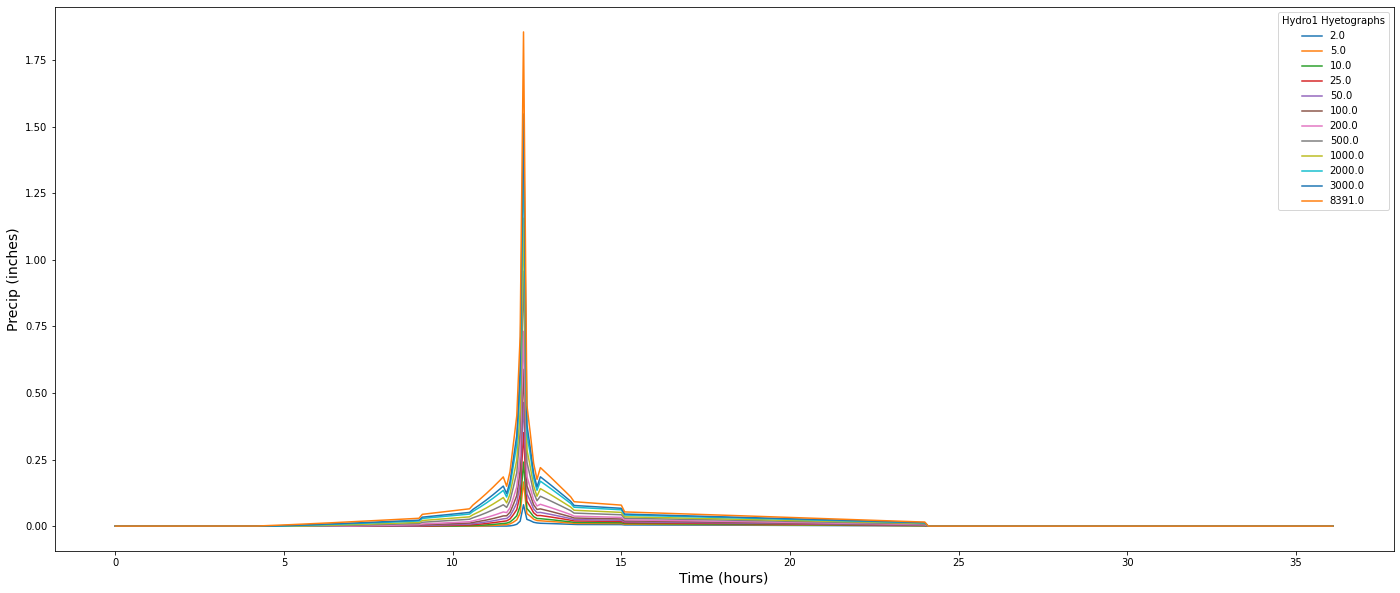

In [122]:
#graph
t_p = final_curves.plot(figsize=(24,10))
t_p.legend(title='Hydro1 Hyetographs')
t_p.set_xlabel('Time (hours)', fontsize=14)
t_p.set_ylabel('Runoff (inches)',fontsize=14)
t_p.plot()

In [62]:
Event_Weights_Hydro = df_weights_rainfall['Event Weight'].to_dict()

rename_map = Rename_Final_Groups_Precip_Stratified(Event_Weights_Hydro,24) #set naming convention
renamed_groups = {}
renamed_tests = {}
renamed_weights = {}

for k, v in rename_map.items():
    renamed_groups[v] = final_curves[k]
    renamed_weights[v] = Event_Weights_Hydro [k]

renamed_weights

{'E2001': 0.5509315903877432,
 'E2002': 0.08455052971208149,
 'E2003': 0.10738456470987413,
 'E2004': 0.02274430760532308,
 'E2005': 0.017086569072053852,
 'E2006': 0.004228143585228472,
 'E2007': 0.005373190919625032,
 'E2008': 0.0011433504708275647,
 'E2009': 0.0008529772076807979,
 'E2010': 0.00020671487795432788,
 'E2011': 0.0001299232650311756,
 'E2012': 0.0002702702702702703}

In [63]:
renamed_curves = final_curves.rename(index=float, columns=rename_map).copy()
renamed_curves = renamed_curves.reindex(sorted(renamed_curves.columns), axis=1)
renamed_curves.head(2)

,E2001,E2002,E2003,E2004,E2005,E2006,E2007,E2008,E2009,E2010,E2011,E2012
hours,,,,,,,,,,,,
0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [64]:
#convert weighting table to pandas dataframe
df_renamed_weights = pd.DataFrame(data = {'Weight':list(renamed_weights.values())}, index = list(renamed_weights.keys())) 
df_renamed_weights 

,Weight
E2001,0.550932
E2002,0.084551
E2003,0.107385
E2004,0.022744
E2005,0.017087
E2006,0.004228
E2007,0.005373
E2008,0.001143
E2009,0.000853
E2010,0.000207


## Save

In [65]:
#write excess rainfall events to json
excess_dic = hydro_out_to_dic(renamed_curves,BCN)

with open(outputs_dir/'{0}_{1}_{2}_{3}.json'.format(Project_Area, Pluvial_Model, BCN,'Hydro1'), 'w') as f:
    json.dump(excess_dic, f)

In [66]:
#write excess rainfall events to dss
forcing = '{0}_{1}_{2}_{3}_Forcing'.format(Project_Area, Pluvial_Model, BCN,'Hydro1')

hydromet_JSON_to_DSS_v2.main(outputs_dir, outputs_dir, bin_dir, forcing, remove_temp_files = True, display_print = True)

Converting Concord_P01_01070005_Hydro1.json to DSS...
Dss File written to C:\Users\mbartlettjr\Documents\GitHub\pfra-hydromet\Notebooks\pluvial\Outputs\Concord_P01_01070005_Hydro1_Forcing.dss


In [67]:
#write event weights to json
with open(outputs_dir/'weights'/'{0}_{1}_{2}_{3}_Weights.json'.format(Project_Area, Pluvial_Model, BCN,"Hydro1"), 'w') as f:
    json.dump(renamed_weights, f)
    
#write recurrence interval to json
with open(outputs_dir/'weights'/'{0}_{1}_{2}_{3}_Recurrence.json'.format(Project_Area, Pluvial_Model, BCN,"Hydro1"), 'w') as f:
    json.dump(rename_map, f)

In [68]:
#write events to excel for reference only
writer = pd.ExcelWriter(outputs_dir/'{0}_{1}_{2}_hyeto_input_Table.xlsx'.format(Project_Area, Pluvial_Model, BCN))

for i, d in enumerate(hydro1_evnts):
    table = runoff_distros1[d][['sim_time','hyeto_input']]
    table.to_excel(writer, sheet_name = 'ras_input_{}'.format(hydro1_evnts[i]))
 
writer.save()

---
## Hydrology 3:
### Retrieve Max Potential Retention Variability and Distribution Parameters:

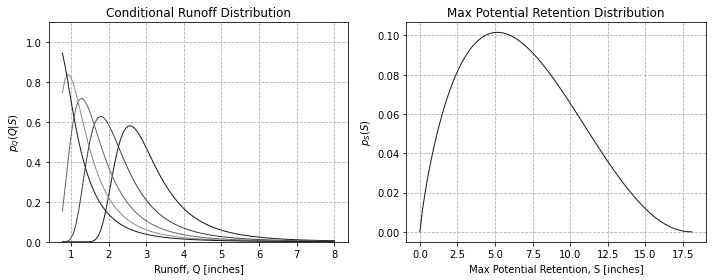

In [69]:
## NRCS value of wet and dry soil moiture conditions:
arc_data = get_CN_distribution(datarepository_dir, CN_Distribution, CN, display_print)

## Table of wet, dry, and average (or median) soil moisture conditions:
df_CN = prep_cn_table(CN, arc_data)  

## Table of parameters for best fit of beta-type distribution to NRCS estiamted dispersion:
fitted_cn = find_optimal_curve_beta_dist_S(df_CN)
fitted_cn['mu'] = mu

## Distribution parameter values:
S_limit = 1000.0/fitted_cn.iloc[0]['CN Lower Limit']-10.0
alpha = fitted_cn.iloc[0]['alpha']
beta = fitted_cn.iloc[0]['beta']

## Define probability for each partition of the max potential retention distribution:
Delta_P = 1.0/n_partition

## Find the average value over each partition, which is the basis for the runoff distribution:
partition_avg = partition_S_avgs(n_partition, Delta_P, alpha, beta, S_limit)

plot_runoff_maxRetention_distributions(GEV_parameters_E, PMP, fitted_cn)

#### Calculate the error in the numerical CDF evaluated at PMP:

In [70]:
## Error between the integral approach (based on summation integration) and the actual value:
error_PQ = 1-CDF_Q(PMP, mu, alpha, beta, S_limit, GEV_parameters_E, PMP, partition_avg, Delta_P, 0)

print('\nProbability of zero runoff = {}\nError in calculation of Probabilibity of zero runoff = {}\n'
      'Error, i.e., the difference between 1 and the numerical CDF evaluated at PMP, Error = {}'
      ''.format(P_Qzero(mu, alpha, beta, S_limit, GEV_parameters_E, PMP, error_PQ)[0], P_Qzero(mu, alpha, beta, S_limit, GEV_parameters_E, PMP, error_PQ)[1], error_PQ))


Probability of zero runoff = 0.0338824573957873
Error in calculation of Probabilibity of zero runoff = 2.586707124735253e-09
Error, i.e., the difference between 1 and the numerical CDF evaluated at PMP, Error = -2.037515580899374e-05


### Determine Runoff Values and Weights:
#### Fit GEV to runoff data (find GEV parameters):

In [71]:
df_runoff, df_GEV_parameters_R = runoff_GEV(mu, GEV_parameters_E, PMP, alpha, beta, S_limit, partition_avg, Delta_P, error_PQ)
GEV_parameters_R = df_GEV_parameters_R.values.transpose()[0]
df_GEV_parameters_R

../../core\hydromet_stratified.py:60: RuntimeWarning:

divide by zero encountered in double_scalars



,GEV Runoff
mu,0.399130
sigma,0.481026
xi,-0.245608


#### Plot fitted rainfall and runoff GEV distributions:

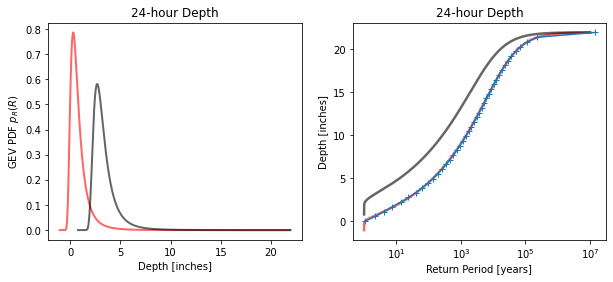

In [72]:
plot_GEV_precip_curves(df_runoff, pd.concat([df_GEV_parameters_R, df_GEV_parameters_E], axis=1), PMP, 'Depth')

#### Runoff weights:

In [73]:
df_weights_runoff = runoff_weights(Return_Intervals, RI_upper_bound, mu, GEV_parameters_R,  GEV_parameters_E, PMP, partition_avg, Delta_P, error_PQ)
df_weights_runoff.head(2)

,Bin Floor,Bin Ceiling,Event Weight,Runoff
2,1.254858,4.106355,0.553378,0.583581
5,4.106355,6.255650,0.083670,1.271357


#### Plot runoff distribution:

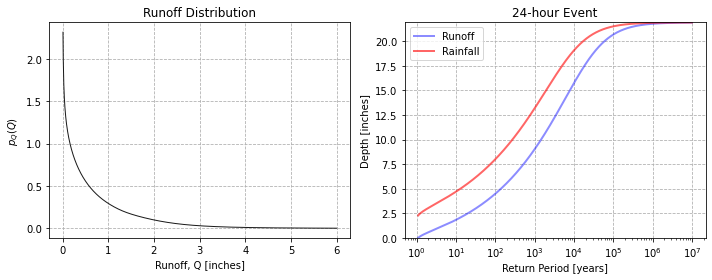

In [74]:
plot_runoff_distributions_final(GEV_parameters_E, GEV_parameters_R, PMP, fitted_cn, partition_avg, Delta_P, error_PQ)

#### Plot maximum potential distribution conditional on runoff:

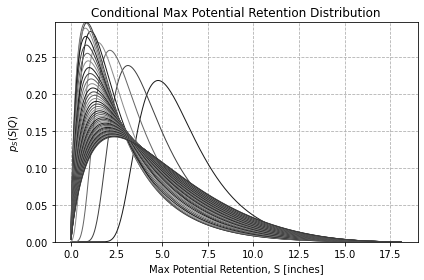

In [75]:
plot_max_potential_retention_cond_runoff(GEV_parameters_E, PMP, fitted_cn, partition_avg, Delta_P, error_PQ)

### Calculate Runoff and Corresponding Max Potential Retention and Rainfall:

In [76]:
df_runoff_SR1 = Scenarios_Avg_S_Median_S(df_weights_runoff, mu, GEV_parameters_E, PMP, partition_avg, Delta_P, alpha, beta, S_limit, error_PQ)
df_runoff_SR1 #.head(2)

,Bin Floor,Bin Ceiling,Event Weight,Runoff,Avg. S,Rainfall (Avg. S),Median S,Rainfall (Median S)
2,1.254858,4.106355,0.553378,0.583581,5.774236,3.305367,5.307623,3.137290
5,4.106355,6.255650,0.083670,1.271357,3.943895,3.752157,3.336438,3.458398
10,6.255650,19.248718,0.107904,1.844099,3.089558,4.098795,2.563685,3.796537
25,19.248718,34.061007,0.022592,2.735942,2.787604,5.007385,2.048765,4.512070
50,34.061007,82.162542,0.017188,3.544698,2.888723,6.008081,2.076714,5.428456
100,82.162542,124.851104,0.004161,4.496502,3.077650,7.210422,2.260138,6.601220
200,124.851104,384.930603,0.005412,5.617761,3.297955,8.608212,2.502258,7.994083
500,384.930603,681.536520,0.001131,7.406035,3.600948,10.777818,2.836298,10.162480
1000,681.536520,1647.672661,0.000860,9.020024,3.826416,12.681683,3.082512,12.065141
2000,1647.672661,2492.309595,0.000206,10.867073,4.041594,14.811780,3.325984,14.202253


### Hydrology 3 Events:
- For each runoff value, two events are considered, a high max potential retention and a low max potential retention

In [77]:
df_runoff_SR2 = Scenarios_low_and_high_S(df_runoff_SR1, mu, GEV_parameters_E, PMP, partition_avg, Delta_P, alpha, beta, S_limit, error_PQ)
df_runoff_SR2 #.head(2)

,Event Weight,Runoff,Avg. S (Lower 50%),Rainfall (Lower 50%),Avg. S (Upper 50%),Rainfall (Upper 50%)
2,0.276689,0.583581,4.086866,2.680837,7.461605,3.891145
5,0.041835,1.271357,2.259472,2.897734,5.628318,4.510830
10,0.053952,1.844099,1.524087,3.140174,4.655030,4.924621
25,0.011296,2.735942,1.079526,3.780434,4.495681,6.031582
50,0.008594,3.544698,1.070844,4.620344,4.706602,7.166164
100,0.002081,4.496502,1.164477,5.689059,4.990823,8.490067
200,0.002706,5.617761,1.299329,6.966069,5.296582,10.003727
500,0.000565,7.406035,1.490598,8.976251,5.711298,12.329287
1000,0.000430,9.020024,1.634155,10.759708,6.018678,14.352545
2000,0.000103,10.867073,1.781339,12.781317,6.301849,16.593703


In [189]:
hydro_events_orig = df_runoff_SR2.index.to_numpy().tolist()
relabel_U = [str(hyetograph)+'_U' for hyetograph in hydro_events_orig]

hydro_events_orig = df_runoff_SR2.index.to_numpy().tolist()
relabel_L = [str(hyetograph)+'_L' for hyetograph in hydro_events_orig]

df_runoff_SR2_U = df_runoff_SR2[['Event Weight', 'Runoff', 'Avg. S (Upper 50%)', 'Rainfall (Upper 50%)']].copy()
df_runoff_SR2_U.rename(columns = {'Avg. S (Upper 50%)': 'Avg. S', 'Rainfall (Upper 50%)': 'Rainfall'}, inplace = True)
df_runoff_SR2_U.index = relabel_U

df_runoff_SR2_L = df_runoff_SR2[['Event Weight', 'Runoff', 'Avg. S (Lower 50%)',  'Rainfall (Lower 50%)']].copy()
df_runoff_SR2_L.rename(columns = {'Avg. S (Lower 50%)': 'Avg. S', 'Rainfall (Lower 50%)': 'Rainfall'}, inplace = True)
df_runoff_SR2_L.index = relabel_L

df_weights_rainfall = df_runoff_SR2_U.append(df_runoff_SR2_L).sort_values(by=['Runoff'])
df_weights_rainfall

,Event Weight,Runoff,Avg. S,Rainfall
2_U,0.276689,0.583581,7.461605,3.891145
2_L,0.276689,0.583581,4.086866,2.680837
5_U,0.041835,1.271357,5.628318,4.510830
5_L,0.041835,1.271357,2.259472,2.897734
10_U,0.053952,1.844099,4.655030,4.924621
10_L,0.053952,1.844099,1.524087,3.140174
25_U,0.011296,2.735942,4.495681,6.031582
25_L,0.011296,2.735942,1.079526,3.780434
50_U,0.008594,3.544698,4.706602,7.166164
50_L,0.008594,3.544698,1.070844,4.620344


In [190]:
RI_list = np.sort(np.concatenate((df_runoff_SR2.index.to_numpy(),df_runoff_SR2.index.to_numpy())))

hyeto_graphs = np.where(RI_list  <1000, RI_list,  1000).astype(int).tolist()
hydro_events = df_weights_rainfall.index.to_numpy().tolist()


precip_distros1 = {}
runoff_distros1 = {}
final_c_input = {}
prep_curves = pd.DataFrame(columns = hydro_events)

for event, hyetograph in zip(hydro_events,hyeto_graphs):
    dist_df = get_hyeto_input_data(nrcs_precip_table_dir, hyetograph,display_print)
    dist_df['precip'] = dist_df['ratio']*df_weights_rainfall['Rainfall'].loc[event]
    s = df_weights_rainfall['Avg. S'].loc[event]
    ia = IA_24hr(s)
    dist_df['excess_precip'] = np.where(dist_df['precip']<= ia ,0,(np.square(dist_df['precip']-ia))/(dist_df['precip']-ia+s))
    dist_df['hyeto_input'] = dist_df['excess_precip'].diff()
    dist_df['hyeto_input'] = dist_df['hyeto_input'].fillna(0.0)
    dist_df['sim_time'] = (dist_df['t_step'].astype(int)).astype(str)+':'+ ((round((dist_df['t_step'] - dist_df['t_step'].astype(int))*60)).astype(int)).astype(str)
    runoff_distros1[event] = dist_df
    prep_curves[event] = dist_df['hyeto_input']

In [191]:
#hyetographs in pandas dataframe
prep_curves.rename_axis('hours')
prep_curves.index = prep_curves.index.astype(float)
extend_curves = prep_curves.loc[0.0:Time_Extend]*0
extend_curves.index = extend_curves.index+24.1
extend_curves.rename_axis('hours')
final_curves = prep_curves.append(extend_curves).rename_axis('hours')

[]

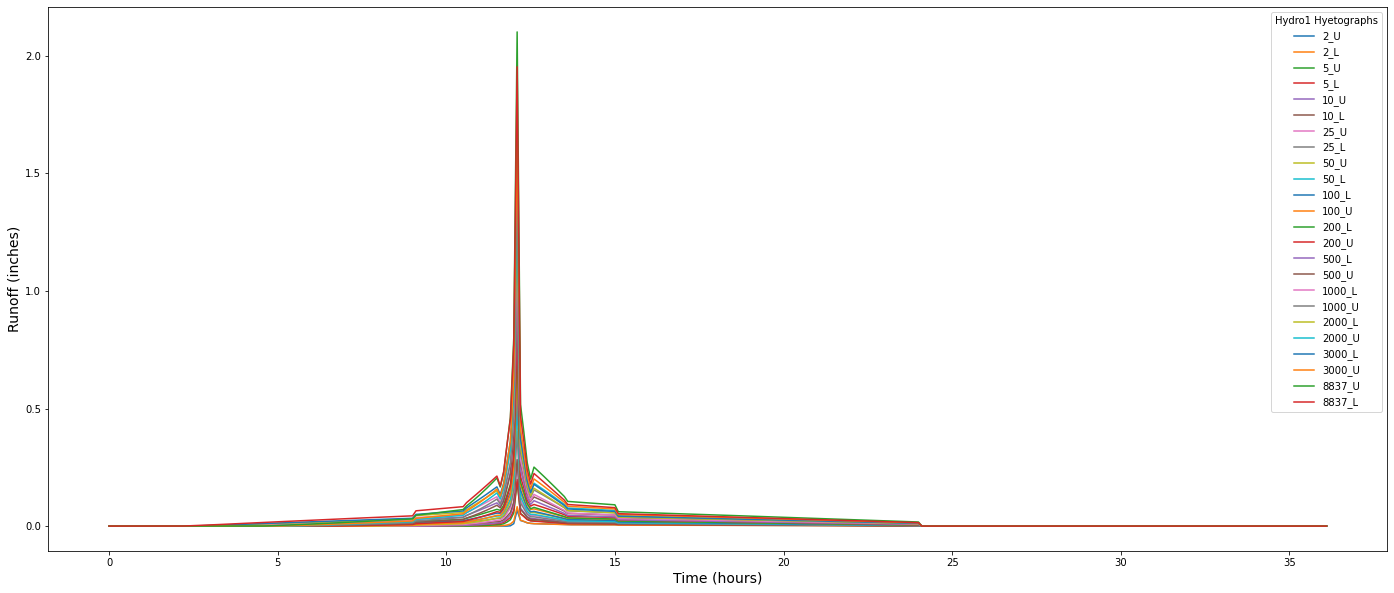

In [175]:
#graph
t_p = final_curves.plot(figsize=(24,10))
t_p.legend(title='Hydro1 Hyetographs')
t_p.set_xlabel('Time (hours)', fontsize=14)
t_p.set_ylabel('Runoff (inches)',fontsize=14)
t_p.plot()

In [176]:
Event_Weights_Hydro = df_weights_rainfall['Event Weight'].to_dict()

rename_map = Rename_Final_Groups_Precip_Stratified(Event_Weights_Hydro,24) #set naming convention
renamed_groups = {}
renamed_tests = {}
renamed_weights = {}

for k, v in rename_map.items():
    renamed_groups[v] = final_curves[k]
    renamed_weights[v] = Event_Weights_Hydro [k]

renamed_weights

{'E2001': 0.27668909192779456,
 'E2002': 0.27668909192779456,
 'E2003': 0.04183475027272211,
 'E2004': 0.04183475027272211,
 'E2005': 0.05395199021692939,
 'E2006': 0.05395199021692939,
 'E2007': 0.011296213748114004,
 'E2008': 0.011296213748114004,
 'E2009': 0.008594044095739977,
 'E2010': 0.008594044095739977,
 'E2011': 0.0020807278463323767,
 'E2012': 0.0020807278463323767,
 'E2013': 0.002705834912467656,
 'E2014': 0.002705834912467656,
 'E2015': 0.0005652990342693429,
 'E2016': 0.0005652990342693429,
 'E2017': 0.0004301780675505916,
 'E2018': 0.0004301780675505916,
 'E2019': 0.0001028412027221352,
 'E2020': 0.0001028412027221352,
 'E2021': 6.548199569171009e-05,
 'E2022': 6.548199569171009e-05,
 'E2023': 0.00013513513513513514,
 'E2024': 0.00013513513513513514}

In [177]:
renamed_curves = final_curves.rename(index=float, columns=rename_map).copy()
renamed_curves = renamed_curves.reindex(sorted(renamed_curves.columns), axis=1)
renamed_curves.head(2)

,E2001,E2002,E2003,E2004,E2005,E2006,E2007,E2008,E2009,E2010,...,E2015,E2016,E2017,E2018,E2019,E2020,E2021,E2022,E2023,E2024
hours,,,,,,,,,,,,,,,,,,,,,
0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [178]:
#convert weighting table to pandas dataframe
df_renamed_weights = pd.DataFrame(data = {'Weight':list(renamed_weights.values())}, index = list(renamed_weights.keys())) 
df_renamed_weights 

,Weight
E2001,0.276689
E2002,0.276689
E2003,0.041835
E2004,0.041835
E2005,0.053952
E2006,0.053952
E2007,0.011296
E2008,0.011296
E2009,0.008594
E2010,0.008594


## Save

In [89]:
#write excess rainfall events to json
excess_dic = hydro_out_to_dic(renamed_curves,BCN)

with open(outputs_dir/'{0}_{1}_{2}_{3}.json'.format(Project_Area, Pluvial_Model, BCN,'Hydro1'), 'w') as f:
    json.dump(excess_dic, f)

In [90]:
#write excess rainfall events to dss
forcing = '{0}_{1}_{2}_{3}_Forcing'.format(Project_Area, Pluvial_Model, BCN,'Hydro1')

hydromet_JSON_to_DSS_v2.main(outputs_dir, outputs_dir, bin_dir, forcing, remove_temp_files = True, display_print = True)

Converting Concord_P01_01070005_Hydro1.json to DSS...
Dss File written to C:\Users\mbartlettjr\Documents\GitHub\pfra-hydromet\Notebooks\pluvial\Outputs\Concord_P01_01070005_Hydro1_Forcing.dss


In [91]:
#write event weights to json
with open(outputs_dir/'weights'/'{0}_{1}_{2}_{3}_Weights.json'.format(Project_Area, Pluvial_Model, BCN,"Hydro1"), 'w') as f:
    json.dump(renamed_weights, f)
    
#write recurrence interval to json
with open(outputs_dir/'weights'/'{0}_{1}_{2}_{3}_Recurrence.json'.format(Project_Area, Pluvial_Model, BCN,"Hydro1"), 'w') as f:
    json.dump(rename_map, f)

In [92]:
#write events to excel for reference only
writer = pd.ExcelWriter(outputs_dir/'{0}_{1}_{2}_hyeto_input_Table.xlsx'.format(Project_Area, Pluvial_Model, BCN))

for i, d in enumerate(hydro_events):
    table = runoff_distros1[d][['sim_time','hyeto_input']]
    table.to_excel(writer, sheet_name = 'ras_input_{}'.format(hydro_events[i]))
 
writer.save()

## Hydrology 4

In [179]:
RI_list = np.sort(np.concatenate((df_runoff_SR2.index.to_numpy(),df_runoff_SR2.index.to_numpy())))

#hyeto_graphs = np.where(RI_list  <1000, RI_list,  1000).astype(int)
Atlas14_hyetographs = ['q1','q2', 'q3','q4']
hydro_events = df_weights_rainfall.index.to_numpy().tolist()


precip_distros1 = {}
runoff_distros1 = {}
final_c_input = {}

column_names = []
for event in hydro_events:
    for hyetograph in Atlas14_hyetographs:
            column_names.append(event+'_'+hyetograph)


prep_curves = pd.DataFrame(columns = column_names )
prep_weights = pd.DataFrame(index = column_names, columns= ['Event Weight'])

for event in hydro_events:
    for hyetograph in Atlas14_hyetographs:
        dist_df, weight_df = get_hyeto_input_data(atlas14_precip_table_dir, hyetograph,display_print)
        dist_df['precip'] = dist_df[hyetograph]*df_weights_rainfall['Rainfall'].loc[event]
        s = df_weights_rainfall['Avg. S'].loc[event]
        ia = IA_24hr(s)
        dist_df['excess_precip'] = np.where(dist_df['precip']<= ia ,0,(np.square(dist_df['precip']-ia))/(dist_df['precip']-ia+s))
        dist_df['hyeto_input'] = dist_df['excess_precip'].diff()
        dist_df['hyeto_input'] = dist_df['hyeto_input'].fillna(0.0)
        #dist_df['sim_time'] = (dist_df['t_step'].astype(int)).astype(str)+':'+ ((round((dist_df['t_step'] - dist_df['t_step'].astype(int))*60)).astype(int)).astype(str)
        runoff_distros1[event] = dist_df
        prep_curves[event+'_'+hyetograph] = dist_df['hyeto_input']
        prep_weights['Event Weight'].loc[event+'_'+hyetograph] = df_weights_rainfall['Event Weight'][event]*weight_df['weight'][hyetograph]

In [180]:
#hyetographs in pandas dataframe
prep_curves.rename_axis('hours')
prep_curves.index = prep_curves.index.astype(float)
extend_curves = prep_curves.loc[0.0:Time_Extend]*0
extend_curves.index = extend_curves.index+24.5
extend_curves.rename_axis('hours')
final_curves = prep_curves.append(extend_curves).rename_axis('hours')

[]

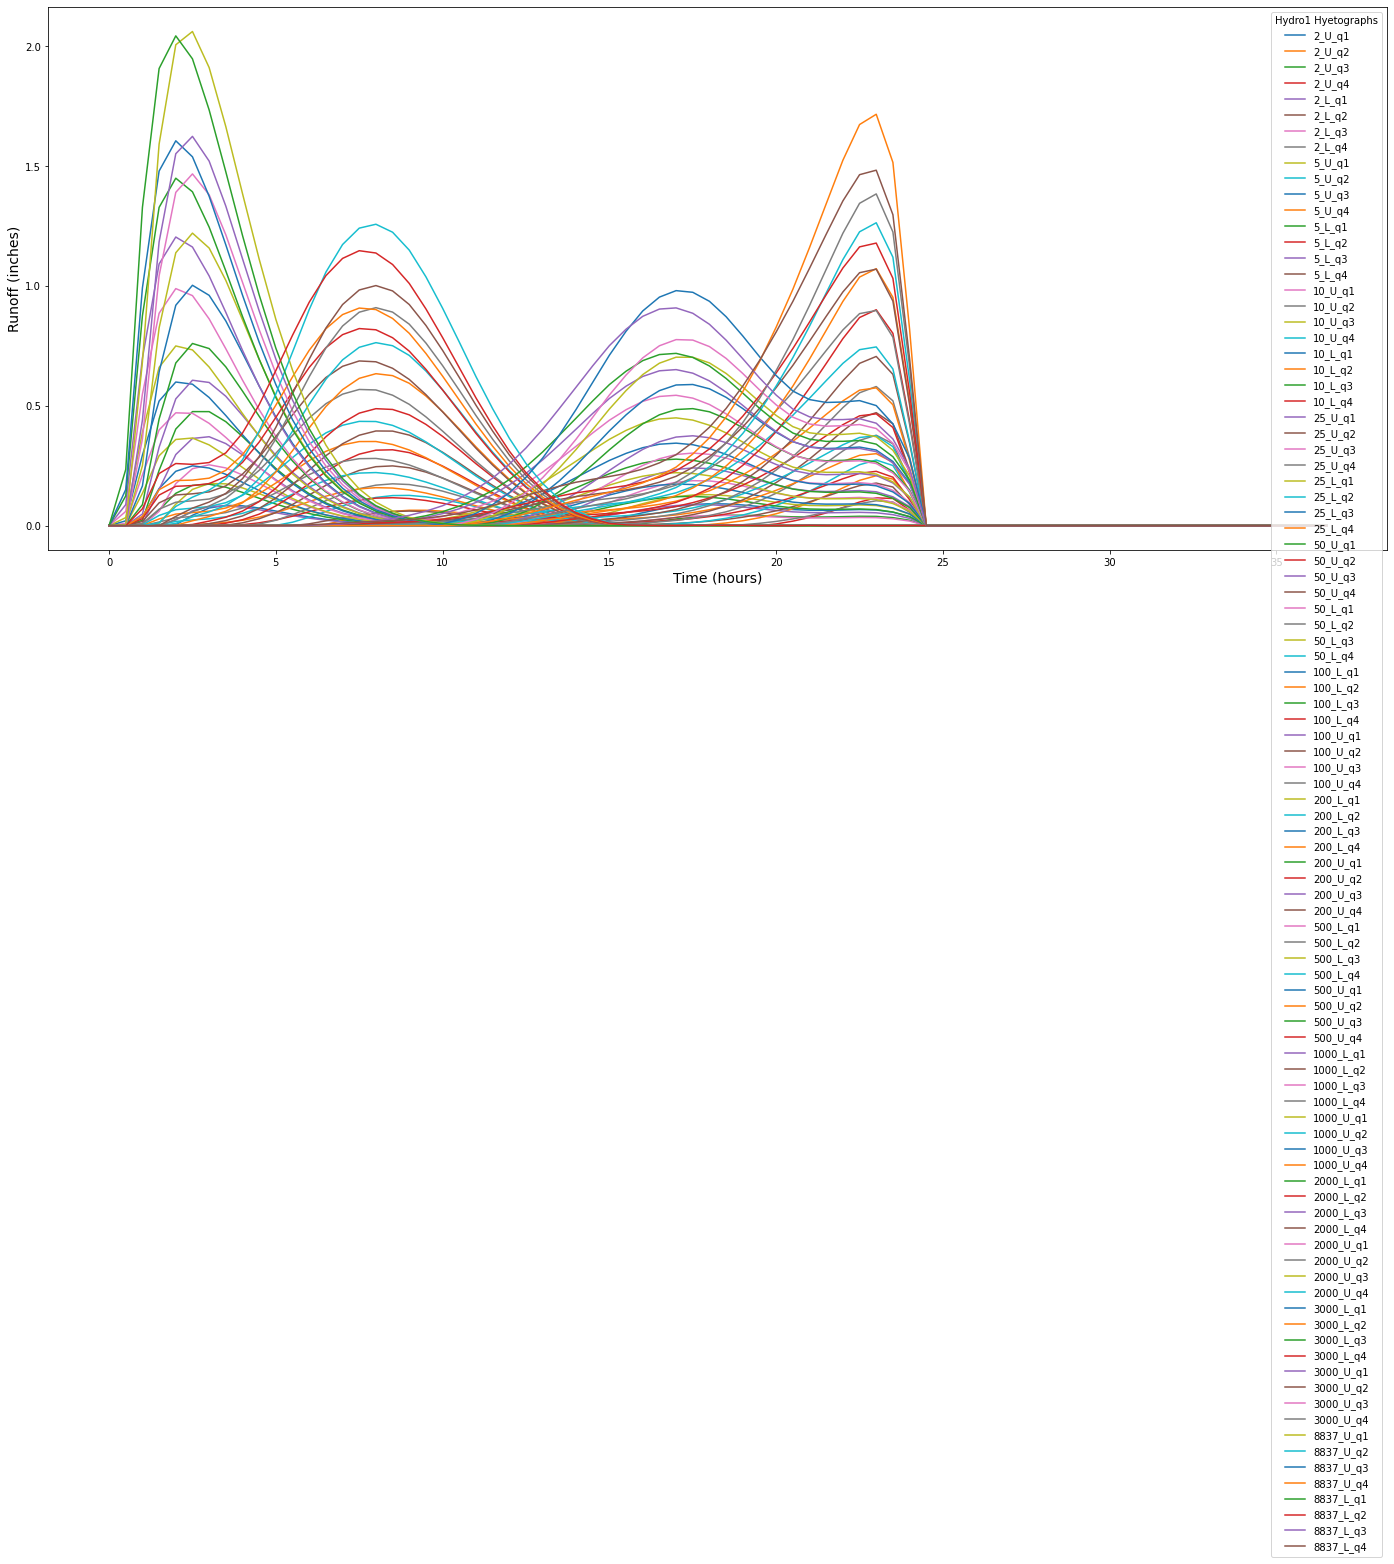

In [181]:
#graph
t_p = final_curves.plot(figsize=(24,10))
t_p.legend(title='Hydro1 Hyetographs')
t_p.set_xlabel('Time (hours)', fontsize=14)
t_p.set_ylabel('Runoff (inches)',fontsize=14)
t_p.plot()

In [182]:
Event_Weights_Hydro = prep_weights['Event Weight'].to_dict()

rename_map = Rename_Final_Groups_Precip_Stratified(Event_Weights_Hydro,24) #set naming convention
renamed_groups = {}
renamed_tests = {}
renamed_weights = {}

for k, v in rename_map.items():
    renamed_groups[v] = final_curves[k]
    renamed_weights[v] = Event_Weights_Hydro [k]

renamed_weights

{'E2001': 0.06363849114339275,
 'E2002': 0.08577361849761632,
 'E2003': 0.08023983665906041,
 'E2004': 0.047037145627725076,
 'E2005': 0.06363849114339275,
 'E2006': 0.08577361849761632,
 'E2007': 0.08023983665906041,
 'E2008': 0.047037145627725076,
 'E2009': 0.009621992562726086,
 'E2010': 0.012968772584543854,
 'E2011': 0.012132077579089412,
 'E2012': 0.0071119075463627595,
 'E2013': 0.009621992562726086,
 'E2014': 0.012968772584543854,
 'E2015': 0.012132077579089412,
 'E2016': 0.0071119075463627595,
 'E2017': 0.01240895774989376,
 'E2018': 0.01672511696724811,
 'E2019': 0.01564607716290952,
 'E2020': 0.009171838336877998,
 'E2021': 0.01240895774989376,
 'E2022': 0.01672511696724811,
 'E2023': 0.01564607716290952,
 'E2024': 0.009171838336877998,
 'E2025': 0.002598129162066221,
 'E2026': 0.0035018262619153414,
 'E2027': 0.003275901986953061,
 'E2028': 0.0019203563371793808,
 'E2029': 0.002598129162066221,
 'E2030': 0.0035018262619153414,
 'E2031': 0.003275901986953061,
 'E2032': 0.001

In [183]:
renamed_curves = final_curves.rename(index=float, columns=rename_map).copy()
renamed_curves = renamed_curves.reindex(sorted(renamed_curves.columns), axis=1)
renamed_curves.head(2)

,E2001,E2002,E2003,E2004,E2005,E2006,E2007,E2008,E2009,E2010,...,E2087,E2088,E2089,E2090,E2091,E2092,E2093,E2094,E2095,E2096
hours,,,,,,,,,,,,,,,,,,,,,
0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00377,0.0,0.0,0.0,0.234693,0.0,0.0,0.0


In [184]:
#convert weighting table to pandas dataframe
df_renamed_weights = pd.DataFrame(data = {'Weight':list(renamed_weights.values())}, index = list(renamed_weights.keys())) 
df_renamed_weights 

,Weight
E2001,0.063638
E2002,0.085774
E2003,0.080240
E2004,0.047037
E2005,0.063638
...,...
E2092,0.000023
E2093,0.000031
E2094,0.000042
E2095,0.000039


## Save

In [103]:
#write excess rainfall events to json
excess_dic = hydro_out_to_dic(renamed_curves,BCN)

with open(outputs_dir/'{0}_{1}_{2}_{3}.json'.format(Project_Area, Pluvial_Model, BCN,'Hydro1'), 'w') as f:
    json.dump(excess_dic, f)

In [105]:
#write excess rainfall events to dss
forcing = '{0}_{1}_{2}_{3}_Forcing'.format(Project_Area, Pluvial_Model, BCN,'Hydro1')

hydromet_JSON_to_DSS_v2.main(outputs_dir, outputs_dir, bin_dir, forcing, remove_temp_files = True, display_print = True)

Converting Concord_P01_01070005_Hydro1.json to DSS...
Dss File written to C:\Users\mbartlettjr\Documents\GitHub\pfra-hydromet\Notebooks\pluvial\Outputs\Concord_P01_01070005_Hydro1_Forcing.dss


In [106]:
#write event weights to json
with open(outputs_dir/'weights'/'{0}_{1}_{2}_{3}_Weights.json'.format(Project_Area, Pluvial_Model, BCN,"Hydro1"), 'w') as f:
    json.dump(renamed_weights, f)
    
#write recurrence interval to json
with open(outputs_dir/'weights'/'{0}_{1}_{2}_{3}_Recurrence.json'.format(Project_Area, Pluvial_Model, BCN,"Hydro1"), 'w') as f:
    json.dump(rename_map, f)

In [107]:
#write events to excel for reference only
writer = pd.ExcelWriter(outputs_dir/'{0}_{1}_{2}_hyeto_input_Table.xlsx'.format(Project_Area, Pluvial_Model, BCN))

for i, d in enumerate(hydro_events):
    table = runoff_distros1[d][['hyeto_input']]
    table.to_excel(writer, sheet_name = 'ras_input_{}'.format(hydro_events[i]))
 
writer.save()

---
## End